# CIAN.ru

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, gc
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score,train_test_split

from sklearn.metrics import make_scorer, mean_squared_error,  mean_absolute_error
from bayes_opt import BayesianOptimization


In [2]:
data = pd.read_csv('Data_cian_full.csv',index_col=0)

In [3]:
data.head()

,District,Price,Tel,combined_bs,cooking_space,dist,floor,house_type,lat,link,living_space,lon,metro_station,metro_time,new,rooms,separate_bs,total_floors,total_space,walk
0,0,528391080,0,0,NaN,2.720885,8,Else,55.749603,150090567,NaN,37.597872,Арбатская,7.0,0,NaN,0,9.0,399.0,1.0
1,0,311298500,1,3,NaN,3.512113,5,монолитный,55.757526,150453732,165.0,37.590632,Баррикадная,10.0,0,5.0,0,7.0,200.0,1.0
2,0,14000000,1,0,8.9,6.482659,5,кирпичный,55.743831,150613273,50.9,37.679835,Римская,5.0,0,3.0,1,5.0,75.5,NaN
3,0,4403057,0,1,NaN,5.864250,3,Else,55.775753,149031353,22.7,37.671938,Красносельская,6.0,1,1.0,0,NaN,22.7,1.0
4,0,4814581,0,1,NaN,5.903571,2,Else,55.776294,148567438,NaN,37.672163,Бауманская,5.0,0,1.0,0,5.0,17.3,1.0


In [4]:
np.sum(data.duplicated())

0

In [5]:
data.shape

(4397, 20)

In [6]:
data.isnull().sum()

District            0
Price               0
Tel                 0
combined_bs         0
cooking_space     781
dist                0
floor               0
house_type          0
lat                 0
link                0
living_space      444
lon                 0
metro_station     599
metro_time        625
new                 0
rooms               4
separate_bs         0
total_floors       68
total_space         0
walk             2040
dtype: int64

In [7]:
data['walk'] = data['walk'].fillna(0)

In [8]:
data['metro_station'] = data['metro_station'].fillna('Нет') 

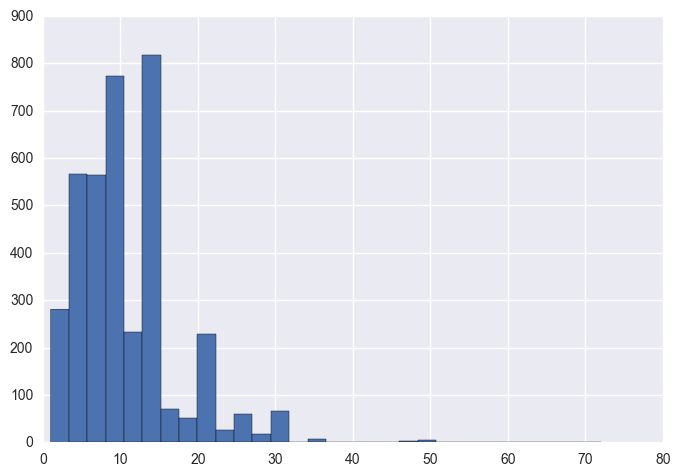

In [9]:
data['metro_time'].hist(bins=30)

### Посмотрим квартиры, которые находятся от метро в 40 минутах

In [10]:
data.ix[data['metro_time']>40,'link']

769     149796933
1508    148356553
2110    150396925
3084    149626095
3459    150818815
4014    148445047
4348    149544711
4393    148848792
Name: link, dtype: int64

Все норм, это не выбросы

In [11]:
data['metro_time'].mean()

11.065747613997878

In [12]:
data['metro_time_non'] = 0
data.loc[data['metro_time'].isnull() ,'metro_time_non'] = 1

In [13]:
data['metro_time'] = data['metro_time'].fillna(data['metro_time'].mean()) 

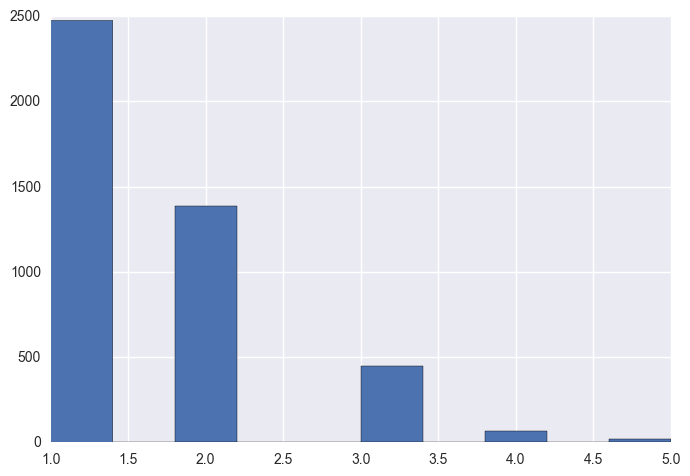

In [14]:
data['rooms'].hist()

In [15]:
data.ix[data['rooms'].isnull(),'link']

0       150090567
422      32637436
1336    149212457
3298      2914190
Name: link, dtype: int64

In [16]:
data['rooms'] = data['rooms'].fillna(6)

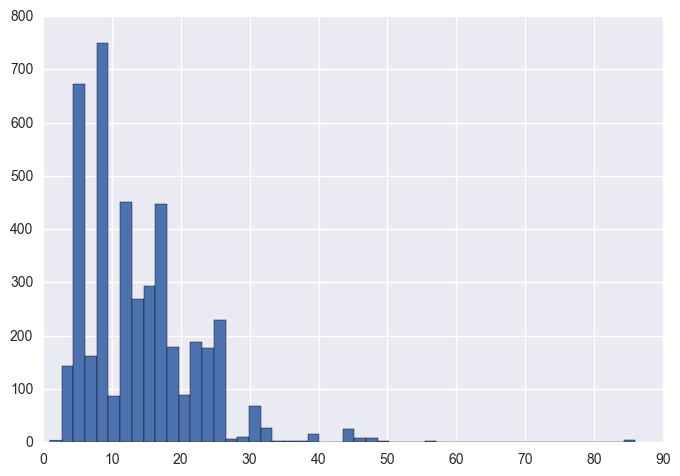

In [17]:
data['total_floors'].hist(bins=50) 

In [18]:
data['total_floors_non'] = 0
data.loc[data['total_floors'].isnull() ,'total_floors_non'] = 1
data['total_floors'] = data['total_floors'].fillna(data['total_floors'].mean()) 

In [19]:
data['living_space_non'] = 0
data.loc[data['living_space'].isnull() ,'living_space_non'] = 1
data['living_space'] = data['living_space'].fillna(data['living_space'].mean())

In [20]:
data['cooking_space_non'] = 0
data.loc[data['cooking_space'].isnull() ,'cooking_space_non'] = 1
data['cooking_space'] = data['cooking_space'].fillna(data['cooking_space'].mean())

In [21]:
def num_cat(data):
    for name in data.columns:
        print(str(name) + '  '+ str(data[name].nunique()))
#Количество уникальных значений
num_cat(data)

District  12
Price  1801
Tel  2
combined_bs  5
cooking_space  188
dist  2733
floor  41
house_type  7
lat  2677
link  4397
living_space  473
lon  2663
metro_station  175
metro_time  37
new  2
rooms  6
separate_bs  5
total_floors  56
total_space  666
walk  2
metro_time_non  2
total_floors_non  2
living_space_non  2
cooking_space_non  2


In [22]:
data.isnull().sum().sum()

0L

In [24]:
data.head()

,District,Price,Tel,combined_bs,cooking_space,dist,floor,house_type,lat,link,...,new,rooms,separate_bs,total_floors,total_space,walk,metro_time_non,total_floors_non,living_space_non,cooking_space_non
0,0,528391080,0,0,9.011864,2.720885,8,Else,55.749603,150090567,...,0,6.0,0,9.00000,399.0,1.0,0,0,1,1
1,0,311298500,1,3,9.011864,3.512113,5,монолитный,55.757526,150453732,...,0,5.0,0,7.00000,200.0,1.0,0,0,0,1
2,0,14000000,1,0,8.900000,6.482659,5,кирпичный,55.743831,150613273,...,0,3.0,1,5.00000,75.5,0.0,0,0,0,0
3,0,4403057,0,1,9.011864,5.864250,3,Else,55.775753,149031353,...,1,1.0,0,13.96535,22.7,1.0,0,1,0,1
4,0,4814581,0,1,9.011864,5.903571,2,Else,55.776294,148567438,...,0,1.0,0,5.00000,17.3,1.0,0,0,1,1


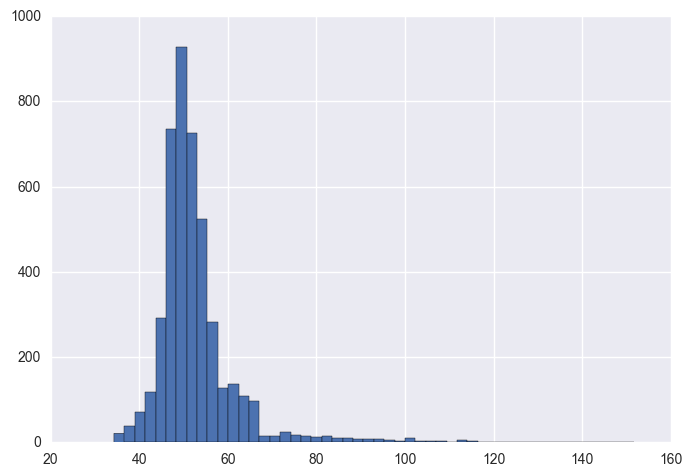

In [15]:
(data['Price']**0.25).hist(bins=50)

In [16]:
data.describe()

,District,Price,Tel,combined_bs,cooking_space,dist,floor,lat,link,living_space,lon,metro_time,new,rooms,separate_bs,total_floors,total_space,walk
count,4397.000000,4.397000e+03,4397.000000,4397.000000,3616.000000,4397.000000,4397.000000,4397.000000,4.397000e+03,3953.000000,4397.000000,3772.000000,4397.000000,4393.000000,4397.000000,4329.000000,4397.000000,2357.0
mean,4.505572,9.910454e+06,0.344326,0.571071,9.011864,17.160947,7.084603,55.727852,1.419186e+08,28.411485,37.565066,11.065748,0.292700,1.582518,0.389356,13.965350,47.985490,1.0
std,3.151581,1.900881e+07,0.475202,0.558465,4.194752,10.517870,5.920011,0.107955,2.785309e+07,17.604585,0.147533,6.342385,0.455053,0.768864,0.535675,8.352073,25.924701,0.0
min,0.000000,1.380000e+06,0.000000,0.000000,1.000000,1.151341,1.000000,55.214892,1.861247e+06,1.000000,36.848282,1.000000,0.000000,1.000000,0.000000,1.000000,13.000000,1.0
25%,2.000000,5.290000e+06,0.000000,0.000000,6.000000,9.691749,3.000000,55.651029,1.488710e+08,19.000000,37.475528,6.000000,0.000000,1.000000,0.000000,8.000000,36.000000,1.0
50%,5.000000,6.603800e+06,0.000000,1.000000,8.250000,16.057230,5.000000,55.738262,1.498933e+08,22.500000,37.561293,10.000000,0.000000,1.000000,0.000000,12.000000,41.800000,1.0
75%,7.000000,9.000000e+06,1.000000,1.000000,10.000000,22.285357,10.000000,55.811295,1.504884e+08,32.000000,37.656092,15.000000,1.000000,2.000000,1.000000,17.000000,53.000000,1.0
max,11.000000,5.283911e+08,1.000000,4.000000,55.500000,91.077575,46.000000,56.002813,1.508224e+08,300.000000,37.940921,72.000000,1.000000,5.000000,4.000000,86.000000,505.000000,1.0


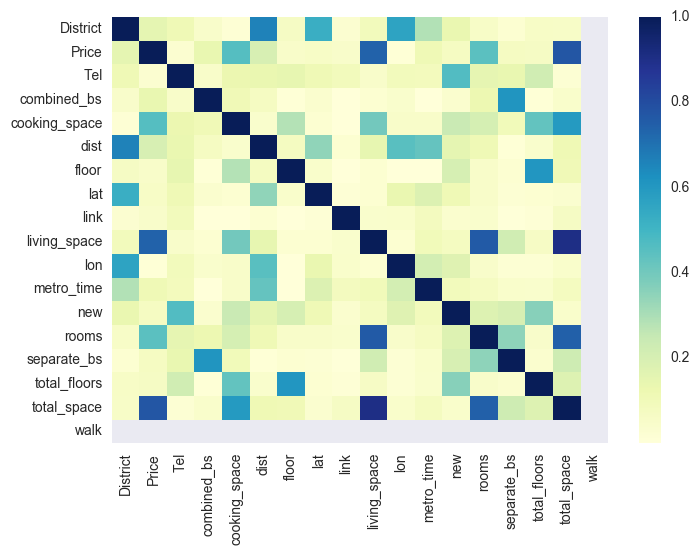

In [17]:
corr = abs(data.corr())
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=False, cmap='YlGnBu')

Сохраним обработанные данные

In [27]:
data.to_csv('Data_cian_full_finished.csv')

Загрузим обработанные данные

In [8]:
data = pd.read_csv('Data_cian_full_finished.csv',index_col=0)

In [9]:
data.head()

,District,Price,Tel,combined_bs,cooking_space,dist,floor,house_type,lat,link,...,new,rooms,separate_bs,total_floors,total_space,walk,metro_time_non,total_floors_non,living_space_non,cooking_space_non
0,0,528391080,0,0,9.011864,2.720885,8,Else,55.749603,150090567,...,0,6.0,0,9.00000,399.0,1.0,0,0,1,1
1,0,311298500,1,3,9.011864,3.512113,5,монолитный,55.757526,150453732,...,0,5.0,0,7.00000,200.0,1.0,0,0,0,1
2,0,14000000,1,0,8.900000,6.482659,5,кирпичный,55.743831,150613273,...,0,3.0,1,5.00000,75.5,0.0,0,0,0,0
3,0,4403057,0,1,9.011864,5.864250,3,Else,55.775753,149031353,...,1,1.0,0,13.96535,22.7,1.0,0,1,0,1
4,0,4814581,0,1,9.011864,5.903571,2,Else,55.776294,148567438,...,0,1.0,0,5.00000,17.3,1.0,0,0,1,1


In [10]:
data.dtypes

District               int64
Price                  int64
Tel                    int64
combined_bs            int64
cooking_space        float64
dist                 float64
floor                  int64
house_type            object
lat                  float64
link                   int64
living_space         float64
lon                  float64
metro_station         object
metro_time           float64
new                    int64
rooms                float64
separate_bs            int64
total_floors         float64
total_space          float64
walk                 float64
metro_time_non         int64
total_floors_non       int64
living_space_non       int64
cooking_space_non      int64
dtype: object

# Линейные Модели

In [11]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

In [12]:
scaled_data = []

f_cat = ['metro_station','house_type']
for f in f_cat:
    dummy = pd.get_dummies(data[f].astype('category'), drop_first=True)

dummy.head()    


,блочный,кирпично-монолитный,кирпичный,монолитный,панельныйдом,сталинский
0,0,0,0,0,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [13]:
dummy.columns = [ u'блочный', u'кирпично-монолитный', u'кирпичный', u'монолитный', u'панельныйдом', u'сталинский']

In [14]:
y = 1.0*data['Price']

In [15]:

scaler = StandardScaler()
data.drop(['link','Price'], axis=1, inplace=True)

f_num = [f for f in data.columns if f not in f_cat]
data[f_num] = scaler.fit_transform(data[f_num])

data.head()

,District,Tel,combined_bs,cooking_space,dist,floor,house_type,lat,living_space,lon,...,new,rooms,separate_bs,total_floors,total_space,walk,metro_time_non,total_floors_non,living_space_non,cooking_space_non
0,-1.429785,-0.724671,-1.022689,-6.692589e-13,-1.373064,0.154645,Else,0.201502,-2.189742e-12,0.222387,...,-0.643293,5.659146,-0.726935,-5.992254e-01,13.541311,0.930326,-0.407056,-0.125332,2.983815,2.151735
1,-1.429785,1.379937,4.349786,-6.692589e-13,-1.297828,-0.352168,монолитный,0.274902,8.183860e+00,0.173308,...,-0.643293,4.376900,-0.726935,-8.405882e-01,5.864361,0.930326,-0.407056,-0.125332,-0.335141,2.151735
2,-1.429785,1.379937,-1.022689,-2.941087e-02,-1.015367,-0.352168,кирпичный,0.148029,1.347426e+00,0.778009,...,-0.643293,1.812408,1.140081,-1.081951e+00,1.061445,-1.074892,-0.407056,-0.125332,-0.335141,-0.464741
3,-1.429785,-0.724671,0.768136,-6.692589e-13,-1.074170,-0.690044,Else,0.443760,-3.422103e-01,0.724476,...,1.554501,-0.752084,-0.726935,-5.936638e-12,-0.975454,0.930326,-0.407056,7.978832,-0.335141,2.151735
4,-1.429785,-0.724671,0.768136,-6.692589e-13,-1.070431,-0.858982,Else,0.448772,-2.189742e-12,0.726001,...,-0.643293,-0.752084,-0.726935,-1.081951e+00,-1.183774,0.930326,-0.407056,-0.125332,2.983815,2.151735


In [16]:
print data.shape
print dummy.shape

(4397, 22)
(4397, 6)


In [17]:
data = pd.merge(data, dummy, left_index=True, right_index=True)

In [18]:
print data.shape
data.head()

(4397, 28)


,District,Tel,combined_bs,cooking_space,dist,floor,house_type,lat,living_space,lon,...,metro_time_non,total_floors_non,living_space_non,cooking_space_non,блочный,кирпично-монолитный,кирпичный,монолитный,панельныйдом,сталинский
0,-1.429785,-0.724671,-1.022689,-6.692589e-13,-1.373064,0.154645,Else,0.201502,-2.189742e-12,0.222387,...,-0.407056,-0.125332,2.983815,2.151735,0,0,0,0,0,0
1,-1.429785,1.379937,4.349786,-6.692589e-13,-1.297828,-0.352168,монолитный,0.274902,8.183860e+00,0.173308,...,-0.407056,-0.125332,-0.335141,2.151735,0,0,0,1,0,0
2,-1.429785,1.379937,-1.022689,-2.941087e-02,-1.015367,-0.352168,кирпичный,0.148029,1.347426e+00,0.778009,...,-0.407056,-0.125332,-0.335141,-0.464741,0,0,1,0,0,0
3,-1.429785,-0.724671,0.768136,-6.692589e-13,-1.074170,-0.690044,Else,0.443760,-3.422103e-01,0.724476,...,-0.407056,7.978832,-0.335141,2.151735,0,0,0,0,0,0
4,-1.429785,-0.724671,0.768136,-6.692589e-13,-1.070431,-0.858982,Else,0.448772,-2.189742e-12,0.726001,...,-0.407056,-0.125332,2.983815,2.151735,0,0,0,0,0,0


In [19]:
data.drop(f_cat, axis=1, inplace=True)


In [20]:
clf = LinearRegression()
GS = GridSearchCV(clf, cv=5,param_grid={'fit_intercept':[True,False]}, verbose=0,scoring=make_scorer(score_func=mean_absolute_error, greater_is_better=False))
                   #param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                    #           "gamma": np.logspace(-2, 2, 5)})

In [21]:
GS.fit(data, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=0)

In [22]:
GS.grid_scores_

[mean: -5649984.32244, std: 1773474.39683, params: {'fit_intercept': True},
 mean: -8227444.48453, std: 2558452.70650, params: {'fit_intercept': False}]

In [23]:
score = np.sqrt(GS.best_score_*(-1.0))
print score

2376.969567


In [24]:
clf = Ridge()

params={"alpha": np.logspace(-5, 5, 50)}
            
GS = GridSearchCV(clf, cv=5,param_grid=params, \
                  verbose=0,scoring=make_scorer(score_func=mean_absolute_error, greater_is_better=False),n_jobs=2)


In [25]:
GS.fit(data, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e-05,   1.59986e-05,   2.55955e-05,   4.09492e-05,
         6.55129e-05,   1.04811e-04,   1.67683e-04,   2.68270e-04,
         4.29193e-04,   6.86649e-04,   1.09854e-03,   1.75751e-03,
         2.81177e-03,   4.49843e-03,   7.19686e-03,   1.15140e-02,
         1....    9.54095e+03,   1.52642e+04,   2.44205e+04,   3.90694e+04,
         6.25055e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=0)

In [26]:
GS.best_params_

{'alpha': 9540.9547634999635}

In [27]:
GS.best_score_

-4579352.472349102

In [28]:
score = np.sqrt(GS.best_score_*(-1.0))

In [29]:
score

2139.9421656552081

## Random forest

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
clf = RandomForestRegressor(n_estimators=100, random_state=9)

params={"max_features": [1.0,0.9,0.8,0.7,0.6],
       "min_samples_leaf": [1,2,3,4,5,10,20,30,40,50]}
            
GS = GridSearchCV(clf, cv=5,param_grid=params, \
                  verbose=0,scoring=make_scorer(score_func=mean_absolute_error, greater_is_better=False),n_jobs=1)


In [92]:
G_fit = GS.fit(data, y)

In [93]:
GS.best_params_

{'max_features': 0.6, 'min_samples_leaf': 3}

In [94]:
np.sqrt(GS.best_score_*(-1.0))

1751.7447247362022

In [36]:
clf = RandomForestRegressor(n_estimators=1000, random_state=9)

params={"max_features": [1.0,0.9,0.8,0.7,0.6,0.5,0.4],
       "min_samples_leaf": [1,2,3,4,5,10,20,30,40,50]}
            
GS = GridSearchCV(clf, cv=5,param_grid=params, \
                  verbose=0,scoring=make_scorer(score_func=mean_absolute_error, greater_is_better=False),n_jobs=-1)

In [37]:
G_fit = GS.fit(data, y)

In [38]:
GS.grid_scores_

[mean: -3161291.74697, std: 2103708.59707, params: {'max_features': 1.0, 'min_samples_leaf': 1},
 mean: -3125999.28810, std: 2173887.10376, params: {'max_features': 1.0, 'min_samples_leaf': 2},
 mean: -3108385.56475, std: 2215749.90877, params: {'max_features': 1.0, 'min_samples_leaf': 3},
 mean: -3118967.60669, std: 2239439.49723, params: {'max_features': 1.0, 'min_samples_leaf': 4},
 mean: -3128977.58883, std: 2265012.66412, params: {'max_features': 1.0, 'min_samples_leaf': 5},
 mean: -3153453.22268, std: 2362603.69047, params: {'max_features': 1.0, 'min_samples_leaf': 10},
 mean: -3238903.63083, std: 2413396.49078, params: {'max_features': 1.0, 'min_samples_leaf': 20},
 mean: -3486781.52324, std: 2434279.80618, params: {'max_features': 1.0, 'min_samples_leaf': 30},
 mean: -3642345.30916, std: 2507935.48117, params: {'max_features': 1.0, 'min_samples_leaf': 40},
 mean: -3690978.04450, std: 2540185.64266, params: {'max_features': 1.0, 'min_samples_leaf': 50},
 mean: -3143093.39768, st

In [39]:
GS.best_params_

{'max_features': 0.6, 'min_samples_leaf': 3}

In [40]:
clf = RandomForestRegressor(n_estimators=10000, random_state=9)

params={"max_features": [0.6],
       "min_samples_leaf": [3]}
            
GS = GridSearchCV(clf, cv=5,param_grid=params, \
                  verbose=0,scoring=make_scorer(score_func=mean_absolute_error, greater_is_better=False),n_jobs=-1)

In [41]:
G_fit = GS.fit(data, y)

In [42]:
GS.grid_scores_

[mean: -3077370.98164, std: 2257628.88262, params: {'max_features': 0.6, 'min_samples_leaf': 3}]

### Итоговый rmse для случайного леса на кросс валидации

In [43]:
np.sqrt(GS.best_score_*(-1.0))

1754.2437064563649